# 🌐 Wikipedia recommender system
- Zuzanna Gawrysiak 148255
- Agata Żywot 148258

### Description (straight from ekursy - to be deleted later)


The general task is to create a system that will recommend similar articles based on the previously visited articles.

**Input - Collection of articles (links or titles), Output - Collection of recommended articles (links or titles) with a "score"**


You will receive a grade for each of the following steps. The highest possible score without
finishing all parts is 4.0. For example, if you do perfectly the first two steps your grades will be 4.0,
4.0, 2.0.


**Crawling and scraping** - Download text from at least 1000 Wikipedia/fandom wiki articles.
(Scrappy is not a must)


**Stemming, lemmatization** - preprocess downloaded documents into the most suitable form for this
task. Store it as a .csv/parquet file or into a database.


**Similarities** - for a given collection of previously visited articles find the best matches in your
database and recommend them to the user


GUI not required, notebook or any other reasonable form will be accepted. I have to be able to
provide a list of articles in an easy way and receive a meaningful recommendation.
You have to send the source code and report.


Report:
- pdf or notebook
- explain each step of your algorithm, especially how you score articles
- present interesting statistics about your database (most frequent words, histograms, similarities
between documents, ...)
- show some examples of recommendations with explanations (I'd prefer graphical form - see
prediction breakdowns for example)

## Import necessary libraries

In [ ]:
%pip install pyldavis
%pip install wikipedia

In [1]:
# SCRAPPING
import random
import linecache
import wikipedia
import re

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from wordcloud import WordCloud

import pyLDAvis
import pyLDAvis.sklearn

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, wordpunct_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\agata\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\agata\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\agata\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Scraping wikipedia articles

In [2]:
N = 1500
with open(r'./data/titles.txt', 'r') as fp:
    num_lines = sum(1 for line in fp)
    # print('Total lines:', num_lines) 

In [3]:
# get N article titles
random.seed(2137)
line_numbers = random.sample(range(1, num_lines), N)

titles = []
for i in line_numbers:
    x = linecache.getline(r'./data/titles.txt', i).strip()
    titles.append(x)
print(titles[:5])

['Thomas_Daniel_Winter', 'Jehane_Beno%C3%AEt', 'Loveless_(comic_book_series)', 'W_Back', 'Kathrein-Stadion']


## Stemming, lemmatization

In [4]:
def preprocess(article):
    """
    Tokenize given article, remove stopwords, numbers, then perform stemming
    """
    preprocessed = []
    porter = PorterStemmer()
    tokenized = word_tokenize(article)
    sw = stopwords.words('english')

    for word in tokenized:
        if word.isalpha() and word not in sw:
            preprocessed.append(porter.stem(word)) # stemming is faster than lematization, but has lower accuracy (can try both later)
    return ' '.join(preprocessed)

In [5]:
def save_pages_content(titles):
    """
    Create a csv file with all pages information necessary
    """
    df = pd.DataFrame({'title':[],
                        'url':[],
                        'body':[]})
    
    for title in titles:
        try: 
            page = wikipedia.page(title)
        except:
            print(f'No page of title {title}!')
            continue 
        d = dict()
        d['title'] = page.title
        d['url'] = page.url
        body = re.sub(r'==.*?==+', '', page.content)
        d['body'] = preprocess(body)
        df.loc[len(df.index)] = [d['title'], d['url'], d['body']]

    df.to_csv('./data/articles.csv', encoding='utf-8', index=False)

In [6]:
save_pages_content(titles)

No page of title Jehane_Beno%C3%AEt!
No page of title Loveless_(comic_book_series)!
No page of title Too_Big_to_Fail!
No page of title M%C3%BCrsel_Bak%C3%BC!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Diocese_of_Mexico!
No page of title Fran%C3%A7ois_Vi%C3%A9te!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Zurla_(disambiguation)!
No page of title Guns_N%27_Roses_discography!
No page of title Albert_W._Hull!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Aenona!
No page of title Live_at_Brixton_Academy_(Mot%C3%B6rhead_album)!
No page of title Hanover,_nh!
No page of title Noh_Haeng-seok!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Aihun!
No page of title Sam_Smith_(businessperson)!
No page of title Luther_B._Bridgers!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Boxed_(disambiguation)!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Budkow!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title John_C._Bailar!
No page of title Joseph-Ir%C3%A9n%C3%A9e-Ren%C3%A9_Hamel!
No page of title Warren_C._Dockum!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Kevin_McIntyre!
No page of title 535_(number)!
No page of title Frederick_Crouch_(politician)!
No page of title (120540)_1994_SK13!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Thomas_Nelson!
No page of title Ninh_Giang!
No page of title National_Gallery,_Dubl%C3%ADn!
No page of title Matrix-free_methods!
No page of title People%27s_Republic_of_China-Singapore_relations!
No page of title James_%26_the_Red_Balloon_%26_Other_Thomas_Adventures!
No page of title 2005_Stanley_Cup_playoffs!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title John_Driscoll_(disambiguation)!
No page of title George_Augustus_Eliott,_1st_Baron_Heathfield_of_Gibraltar!
No page of title Diving_ant!
No page of title Park_Kyung-hwan!
No page of title Tr%E1%BA%A7n_T%E1%BB%AD_B%C3%ACnh!
No page of title Guyana_Russia_relations!
No page of title Jaan_(given_name)!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Board_of_Equalization_(disambiguation)!
No page of title Charles_F._Roos!
No page of title Greene_Township,_Jay_County,_Indiana!
No page of title Kisp%C3%A1l_%C3%A9s_a_borz!
No page of title N%C3%BDvltov%C3%A1!
No page of title U.S.S._Michigan_(SSGN_727)!
No page of title Renshaw_(last_name)!
No page of title Episodes_of_Smallville_(Season_2)!
No page of title List_of_anti-nuclear_protests_in_the_United_States!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title 12618_Cellarius!
No page of title Broad-leafed_oleaster!
No page of title H%C3%B6lder_(surname)!
No page of title John_Fisher_(politician)!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Natas_(band)!
No page of title Kr%C3%AD%C5%BEovany!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title James_Pritchard_(disambiguation)!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Near_South_Side!
No page of title Andrei_B%C4%83rbulescu!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title John_Fleetwood!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title LIML!
No page of title YTMA!
No page of title BWV_75!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Dinglewood_Historic_District!
No page of title Z%C3%B6llner_(crater)!
No page of title Hurab,_Fars!
No page of title Liberal_Party_candidates,_2007_Manitoba_provincial_election!
No page of title Trzeb%C3%B3rz-Podborze!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Willow_Township_(disambiguation)!
No page of title Open_Med_(Warsaw)!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Skarzyn!
No page of title ICL_20s_Grand_Championship_2007%E2%80%9308!
No page of title Switch_shot_(cricket)!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Splendid_Treefrog!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Someshvar!
No page of title AMDA_%E2%80%93_The_Society_for_Post-Acute_and_Long-Term_Care_Medicine!
No page of title I%C5%8Bgor_%C3%81ntte_%C3%81ilu_Gaup!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Shuyskoye!
No page of title Putin_(surname)!
No page of title Br%C3%B8derbund_Software,_Inc.!
No page of title Waylla_Hirka_(Cajatambo)!
No page of title Frederick_H._Borsch!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Kasha-Veshakh!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Jesse_Campbell!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Shake_(disambiguation)!
No page of title Imad_Hamdi!
No page of title Legislative_Route_123_(California_pre-1964)!
No page of title House_Mountain_(Knox_County,_Tennessee)!
No page of title Vipera_(Echis)_superciliosa!
No page of title Glasnost_(album)!
No page of title Felipe_Coss%C3%ADo_del_Pomar!
No page of title Alexander_Gonzalez!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Gorodovikovski!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title The_Wolf_Hunters!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Dark_Dungeon!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Bermudo!
No page of title Airea_D._Matthews!
No page of title Seminole_County,_GA!
No page of title Clarisse_(Percy_Jackson)!
No page of title 8422_Mohorovi%C4%8Di%C4%87!
No page of title %C5%BDem%C4%97patis!
No page of title Wong_Uk!
No page of title Guesa_%E2%80%93_Gorza!
No page of title Browncos!
No page of title Ces%C3%A1reo_Gonz%C3%A1lez!
No page of title (%2B)-sabinene_3-hydroxylase!
No page of title Gena_Davis!
No page of title Windows_2000_Server!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Porali!
No page of title %C3%96ttingen-%C3%96ttingen!
No page of title Worcestershire_Eastern_(UK_Parliament_constituency)!
No page of title William_Petersen!
No page of title Cote_d%27Azur,_France!
No page of title Surrey_(disambiguation)!
No page of title Kinner_C-5!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Sarrud!
No page of title Chesapeake_%26_Delaware_Canal_Bridge!
No page of title Ch%C5%ABnqi%C5%AB_Sh%C3%ADd%C3%A0i!
No page of title Cosmo_Newbery_(Yilka)!
No page of title Carrick_(Parliament_of_Ireland_constituency)!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Lanier_House!
No page of title Jo_Seong-ha!
No page of title Sch%C3%B6ckel!
No page of title Symphony_No._103!
No page of title Sally_Miller_(disambiguation)!
No page of title Kid_%27n_Play%27s_Funhouse!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title GCET!
No page of title Buffalo_Creek_(Appomattox_River)!
No page of title Goshen_Township,_Auglaize_County,_Ohio!
No page of title Boys_Boys_Boys_(Grace_song)!
No page of title Atlas_(DC_Comics)!
No page of title Chemical_Manufacturers%27_Association!
No page of title Salmeron_(surname)!
No page of title Saint_Michael%27s_Lower_Primary_School,_Kottappuram!
No page of title Concordia_(Ala.)_Hornets!
No page of title Javier_Methol!
No page of title Bare_(Posu%C5%A1je)!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Jaddaim!
No page of title Presidente_Fidel!
No page of title H%C3%A9ctor_Reynoso!
No page of title Will_K._Kaynor!
No page of title Pia_(album)!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Milkeh!
No page of title Edmund_Backhouse,_M.P._for_Darlington!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Cowen_(disambiguation)!
No page of title Piano_(George_Shearing_album)!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Chris_White_(American_football)!
No page of title SR_300_(GA)!
No page of title Almal%C4%83u_River!
No page of title Le_tr%C3%A9sor_de_la_cit%C3%A9_des_dames!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Bentley,_Joseph!
No page of title Bobbi_Harlow!
No page of title Colors_(Crossfade_song)!
No page of title Upin_%26_Ipin_Jeng_Jeng_Jeng!!
No page of title Alika_Adams!
No page of title Herkules_mit_dem_Nemeischen_L%C3%B6wen!
No page of title A%C3%AFn_Djeloula!
No page of title ISO_639:ghl!
No page of title Moby_Prince!
No page of title Michael_O%27Brien_(Fianna_F%C3%A1il_politician)!
No page of title Alliance_Nationale_R%C3%A9publicaine!
No page of title La_Salle_County,_Texas!
No page of title Ba%C5%9Fbakanl%C4%B1k_Koruma!
No page of title Katherine_Lanasa!
No page of title Jo%C3%A3o_Rafael_Kapango!
No page of title Homert_(Lennegebirge)!
No page of title The_Collector_(disambiguation)!
No page of title First_M%C4%81ori_elections!
No page of title Tony_Wright_(Staffordshire_politician)!
No page of title College_of_Aeronautics!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title PA_62!
No page of title Campbell,_Brad!
No page of title Zbogom_no%C4%87i,_zbogom_zore!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title WPAS!
No page of title Crix%C3%A1s_do_Tocantins!
No page of title Grande-Anse_Department!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Tennman!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Masurian_(disambiguation)!
No page of title Christian_anti-Semitism!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Convex_(disambiguation)!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Bloom_field!
No page of title 1974%E2%80%9375_Isthmian_League!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Helen_Grey!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Ganesh_Temple_(disambiguation)!
No page of title 2010%E2%80%9311_Uruguayan_Primera_Divisi%C3%B3n_season!
No page of title Scalar_quantities!
No page of title Force_d%27Action_Navale!
No page of title Highway_83_(MO)!
No page of title Warrensville_%E2%80%93_Shaker_(RTA_Rapid_Transit_station)!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Violations!
No page of title Mehmet_Y%C4%B1lmaz_(footballer,_born_1988)!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Touch_of_Sin_(disambiguation)!
No page of title Daddy%27s_Little_Girl_(The_4400_episode)!
No page of title CR_S19_(CA)!
No page of title The_Gift_of_Valor!
No page of title BM-27_Uragan!
No page of title Big_momma!
No page of title Michelle_Valentine!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title The_Universal_Masters_Collection!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Javier_Caceres!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Gholami!
No page of title Nyak%C3%A9l%C3%A9,_Littoral_Region,_Cameroon!
No page of title Joseph_P._Riley_Jr._Park!
No page of title Min_k%C3%A4rlekss%C3%A5ng_till_dej!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Greenjackets!
No page of title Heartbreaks_(song)!
No page of title Substituted_alpha-alkyltryptamine!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Magnus_Jensen!
No page of title Moonblood!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Hawkenbury!
No page of title Kamenica_(Vi%C5%A1egrad)!
No page of title F%C3%A9lix_Le_Pelletier_de_La_Houssaye!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title BNSF!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Snuffles!
No page of title Angers_(meteorite)!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Simon_Meredith!
No page of title Tetrarch_(Well_of_Echoes)!
No page of title We_(band)!
No page of title Nicole_Beukers!
No page of title Pat_Brisco!
No page of title Karl_Krause_(SS_officer)!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title RORB!
No page of title Joan_Rogers!
No page of title Masna%60At_al-Qa%60!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Wakonda!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Pasko!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Bashkol!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title KGVO-FM!
No page of title Civil_Action_No._02-CV-1130!
No page of title Cycleway_in_Bogot%C3%A1!
No page of title LeCl%C3%A9zio!
No page of title Spiderman_theme!
No page of title Lagard%C3%A8re!
No page of title Edwin_O%27Conner!
No page of title NTNC!
No page of title Ultra-processed_products!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Sergey_Kozlov_(disambiguation)!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Neno!
No page of title Riviere-du-Loup_(river)!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Yapu_Qullu_(Mejillones)!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title CBC_Winnipeg_(disambiguation)!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title QandA!
No page of title Jurjevac_Punitova%C4%8Dki!
No page of title Montreal_-_Senneterre_train!
No page of title Whale_Music_(movie)!
No page of title Blueslide,_Washington!
No page of title House_of_Domagojevi%C4%87!
No page of title Simon_Angell!
No page of title 2014%E2%80%9315_Turlock_Express_season!
No page of title L%27%C3%A9l%C3%A9gance_du_h%C3%A9risson!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Ludwig,_Missouri!
No page of title Seat_License!
No page of title Thanh_T%C3%B9ng!
No page of title Palais_d%27Egmont!
No page of title Shut-in_(river)!
No page of title Goodwill_Inc.!
No page of title Rorik,_11th_of_Lewes!
No page of title Kozar%C3%AB,_Albania!
No page of title Lawrence_Township,_New_Jersey!
No page of title Barry_Johnston!
No page of title Popovici_B%C4%83n%C4%83%C8%9Beanul!
No page of title New_Zealand_cricket_team_in_India_in_2003%E2%80%9304!
No page of title George_F._Veenker!
No page of title K%C3%A4hlerian!
No page of title St_Katherine%27s,_Friern_Barnet!
No page of title Grand_Duchess_Maria_Pavlovna_of_Russia_(1890%E2%80%931958)!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Donald_Stuart!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title RRK!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Bookham_(disambiguation)!
No page of title Luce_(band)!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Michael_Quinlan_(musician)!
No page of title Alexa_%26_Katie!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title God_Is_Able_(disambiguation)!
No page of title Willowcreek,_Oregon!
No page of title USS_Fidelity_(MSO-443)!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Zakir!
No page of title TA/DA_scam!
No page of title Philip_von_H%C3%B6rnigk!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Path_of_Destruction_(disambiguation)!
No page of title Adrian_%26_the_Mysterious_D!
No page of title Nothing_As_It_Seems_(Fringe)!
No page of title US_Special_Forces!
No page of title 2008%E2%80%9309_Be%C5%9Fikta%C5%9F_JK_season!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Powers_of_Ten_(disambiguation)!
No page of title Lantenay,_Cote-d%27Or!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Cotton_Exchange!
No page of title White-striped_free-tailed_bat!
No page of title Francis_J._Lantry!
No page of title Tung_River!
No page of title Dovletabad%E2%80%93Salyp_Yar_pipeline!
No page of title Jin_Au-Yeung!
No page of title Sanchez-Llamas_v._Oregon!
No page of title B%C3%A9rchules,_Spain!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title Bachelor_Creek!


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


No page of title William_E._Walsh!


In [13]:
df = pd.read_csv('./data/articles.csv')
df.tail()

,title,url,body
1154,Rathnew GAA,https://en.wikipedia.org/wiki/Rathnew_GAA,rathnew gaa gaelic footbal club rathnew counti...
1155,Muhammad ibn Abd al-Wahhab,https://en.wikipedia.org/wiki/Muhammad_ibn_Abd...,muhammad ibn abd ibn sulayman arab محمد بن عبد...
1156,Sorel-Tracy Éperviers,https://en.wikipedia.org/wiki/Sorel-Tracy_%C3%...,the épervier hawk hockey team base quebec the ...
1157,Jacob Tonson,https://en.wikipedia.org/wiki/Jacob_Tonson,jacob tonson sometim refer jacob tonson elder ...
1158,William Arnald,https://en.wikipedia.org/wiki/William_Arnald,william arnald bd die august canon windsor he ...


In [14]:
# TO BE DELETED
text = """Poznań University of Technology, PUT (Polish name: Politechnika Poznańska) is a university in Poznań, 
Poland. Poznań University of Technology is known as one of the best technical universities in Poland. URAP 
ranked PUT as in top 6% of world universities and Webometrics ranked it at no. 842 in the world by Google 
citations for the year 2015. In 1995 it became the first Polish university to become a member of the Conference 
of European Schools for Advanced Engineering Education and Research (CESAER), an organization comprising the best 
technical universities in Europe. The university is also a member of the Socrates-Erasmus programme for exchange 
students from all over Europe, promoting advanced engineering and a European dimension. The university is home to 
many organizations and student circles, and the radio station Afera 98.6 MHz. The university has over 
21,000 students and over 1100 academic staffs.""".replace('\n',' ')
text2 = "TFIDF (term frequency–inverse document frequency) is a much better approach. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general."
text3 = "This tradition dates back to pagan times, when during the autumn feast the gods were offered sacrifices of oxen or, as a substitute, of dough rolled up in oxen horns. The Latin Church has taken over this custom and linked it to the figure of St Martin. The shape of the dough was interpreted as a reference to the horseshoe that the holy horse was to lose. In Poznań, the tradition of baking 'rogal świętomarciński' on 11 November certainly existed in 1860, when the oldest known advertisement for the rogal świętomarciński was published in Dziennik Poznański."

articles = pd.DataFrame([["PUT", text],
                        ["bla bla", text2],
                         ["rogal", text3]],
                         columns = ['URL','body'])

for a in articles.body:
    articles = articles.replace(a, preprocess(a))
articles

,URL,body
0,PUT,poznań univers technolog put polish name polit...
1,bla bla,tfidf term document frequenc much better appro...
2,rogal,thi tradit date back pagan time autumn feast g...


### Count vector
Store articles as numbers of occurences of words.

In [15]:
CountVec = CountVectorizer(ngram_range=(1,1), stop_words='english')
CountData = CountVec.fit_transform(df.body)
 
CountData
# if dataset is too large, try: https://scikit-learn.org/stable/modules/feature_extraction.html#vectorizing-a-large-text-corpus-with-the-hashing-trick 

<1159x52056 sparse matrix of type '<class 'numpy.int64'>'
	with 377516 stored elements in Compressed Sparse Row format>

In [17]:
pd.set_option('display.max_columns', 1000)
dfCV = pd.DataFrame(CountData.toarray(), columns=CountVec.get_feature_names_out(), index=df.url)
# dfCV

## Database analysis
> present interesting statistics about your database (most frequent words, histograms, similarities between documents, ...)

### Most frequent words

Top five most frequent words:
use       4615
state     3923
new       3063
includ    2721
unit      2652
dtype: int64


<AxesSubplot:title={'center':'Most frequent words'}>

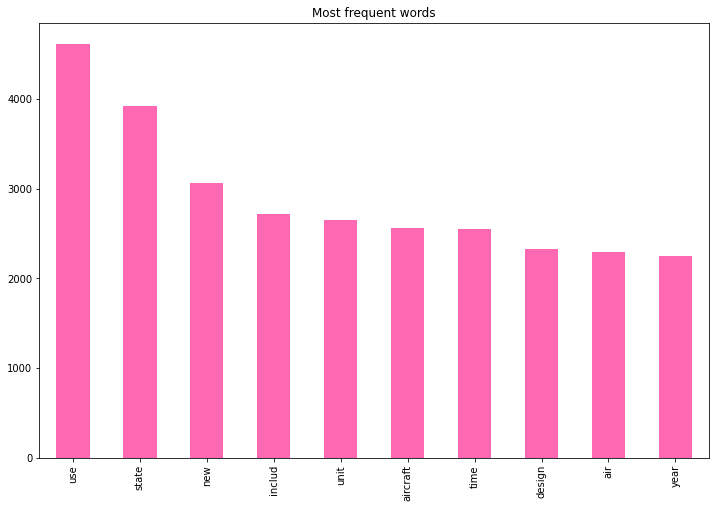

In [18]:
word_sums = dfCV.sum(axis=0)
word_sums = word_sums.sort_values(ascending=False)
print(f"Top five most frequent words:\n{word_sums[:5]}")
word_sums[:10].plot(kind='bar', figsize=(12,8), title="Most frequent words", color='hotpink')

All words as a wordcloud

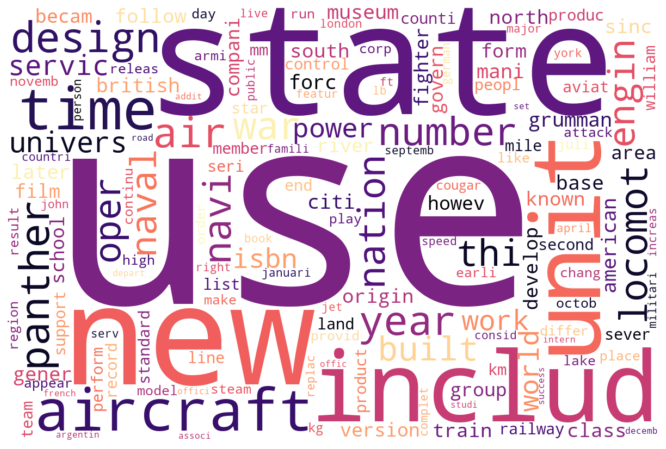

In [19]:
def generate_wordcloud(data):
    wc = WordCloud(width=1200, height=800, max_words=150, background_color='white', colormap='magma').generate_from_frequencies(data)
    plt.figure(figsize=(12,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

generate_wordcloud(word_sums)

### Similarities between documents

Check the similarities using LDA (Latent Drichlet Allocation). 

In [20]:
lda_tf = LatentDirichletAllocation(n_components=3, random_state=0) # number of articles
lda_tf.fit(CountData)

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_tf, CountData, CountVec, mds='tsne')
panel

c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\ag

PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
2     -1015.700562  1338.981201       1        1  42.696081
1      -387.996002  -373.316162       2        1  36.610932
0     -2184.745605   -60.565800       3        1  20.692987, topic_info=           Term         Freq        Total Category  logprob  loglift
818    aircraft  2276.000000  2276.000000  Default  30.0000  30.0000
33297   panther  1994.000000  1994.000000  Default  29.0000  29.0000
30669      navi  1747.000000  1747.000000  Default  28.0000  28.0000
808         air  2053.000000  2053.000000  Default  27.0000  27.0000
30656     naval  1528.000000  1528.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
11365    design   863.596723  2161.684658   Topic3  -5.3372   0.6578
42816     state  1029.040493  3680.534755   Topic3  -5.1619   0.3009
48945       war   715.873234  1825.892960   Topic3  -5.5248   0.6391
35407     power   599.187094  1449.677712   Topic3  -5.7027   0.6919
3797       base   571.080951  1252.742075   Topic3  -5.7508   0.7898

[257 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
561        3  0.995974  aeronav
596        3  0.997577      afb
808        1  0.090586      air
808        2  0.016559      air
808        3  0.892712      air
...      ...       ...      ...
50355      1  0.506294     year
50355      2  0.406153     year
50355      3  0.087565     year
50850      1  0.979970     zinc
50850      2  0.019055     zinc

[431 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

### Conclusions from analysis
* the most frequent word is ...
* bla bla

## TFIDF approach
Count vector was for showing some interesteing statistics, but for the recommendation we will use TFIDF.

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1,1), use_idf=True, smooth_idf=False, stop_words='english') 
tfidf_data = tfidf.fit_transform(articles.body) 
dfTFIDF = pd.DataFrame(tfidf_data.toarray(), index=articles.URL, columns=tfidf.get_feature_names_out())
dfTFIDF

Save the obtained data frame to csv file.

In [ ]:
dfTFIDF.to_csv('articles.csv')

## Similarities

In [ ]:
query = "poznań"
query = preprocess(query)
query = tfidf.transform([query]).toarray()[0] 
1-dfTFIDF.apply(lambda x: cosine(x, query), axis=1).sort_values()